In [1]:
import pandas as pd
import numpy as np

In [2]:
!git clone https://github.com/ashmitg/cxr-image-analysis

Cloning into 'cxr-image-analysis'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 941 (delta 1), reused 4 (delta 1), pack-reused 932 (from 1)
Receiving objects: 100% (941/941), 793.32 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (514/514), done.


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Test_set_prediction_with_relative_image_paths_first_70_unique.csv')


In [4]:
df.size

6171

In [5]:
df.head()

,subject_id,age,race,gender,pred_0,label_0,pred_1,label_1,pred_2,label_2,pred_3,label_3,pred_4,label_4,pred_5,label_5,image_path
0,11812752,68,WHITE,F,0.056143,0,0.015012,0,0.001175,0,0.004269,0,0.091285,0,0.759478,1,cxr-image-analysis/files/p11/p11812752/s582931...
1,11812752,68,WHITE,F,0.051060,0,0.006028,0,0.001799,0,0.006515,0,0.050387,0,0.863849,1,cxr-image-analysis/files/p11/p11812752/s582931...
2,11812752,68,WHITE,F,0.021372,0,0.004059,0,0.000743,0,0.004475,0,0.092967,0,0.849508,1,cxr-image-analysis/files/p11/p11812752/s584125...
3,11812752,68,WHITE,F,0.031842,0,0.001862,0,0.000797,0,0.006196,0,0.047191,0,0.934808,1,cxr-image-analysis/files/p11/p11812752/s584125...
4,15197921,-1,NaN,NaN,0.034598,0,0.010697,0,0.000503,0,0.005243,0,0.077575,0,0.871780,1,cxr-image-analysis/files/p15/p15197921/s595509...


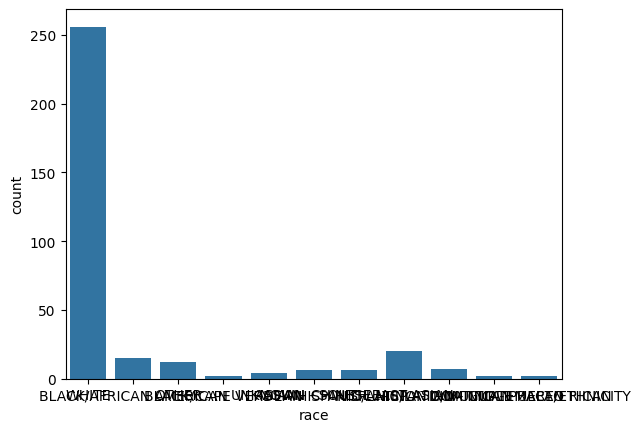

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='race', data=df)
plt.show()


In [7]:
for i in range(6):
    df[f'diff_{i}'] = np.abs(df[f'pred_{i}'] - df[f'label_{i}'])

df['avg_difference'] = df[[f'diff_{i}' for i in range(6)]].mean(axis=1)

threshold = df['avg_difference'].median()

df['classification'] = np.where(df['avg_difference'] <= threshold, 'high-scoring', 'low-scoring')

high_scoring_images = df[df['classification'] == 'high-scoring']
low_scoring_images = df[df['classification'] == 'low-scoring']

In [8]:
df.head()

,subject_id,age,race,gender,pred_0,label_0,pred_1,label_1,pred_2,label_2,...,label_5,image_path,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,avg_difference,classification
0,11812752,68,WHITE,F,0.056143,0,0.015012,0,0.001175,0,...,1,cxr-image-analysis/files/p11/p11812752/s582931...,0.056143,0.015012,0.001175,0.004269,0.091285,0.240522,0.068068,high-scoring
1,11812752,68,WHITE,F,0.051060,0,0.006028,0,0.001799,0,...,1,cxr-image-analysis/files/p11/p11812752/s582931...,0.051060,0.006028,0.001799,0.006515,0.050387,0.136151,0.041990,high-scoring
2,11812752,68,WHITE,F,0.021372,0,0.004059,0,0.000743,0,...,1,cxr-image-analysis/files/p11/p11812752/s584125...,0.021372,0.004059,0.000743,0.004475,0.092967,0.150492,0.045685,high-scoring
3,11812752,68,WHITE,F,0.031842,0,0.001862,0,0.000797,0,...,1,cxr-image-analysis/files/p11/p11812752/s584125...,0.031842,0.001862,0.000797,0.006196,0.047191,0.065192,0.025513,high-scoring
4,15197921,-1,NaN,NaN,0.034598,0,0.010697,0,0.000503,0,...,1,cxr-image-analysis/files/p15/p15197921/s595509...,0.034598,0.010697,0.000503,0.005243,0.077575,0.128220,0.042806,high-scoring


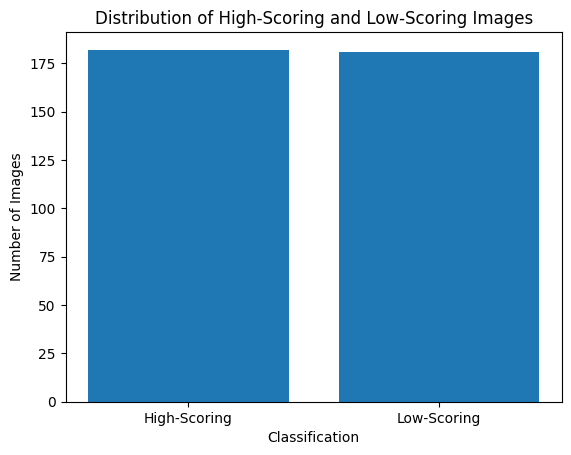

In [9]:
import matplotlib.pyplot as plt

high_scoring_count = len(high_scoring_images)
low_scoring_count = len(low_scoring_images)

labels = ['High-Scoring', 'Low-Scoring']
counts = [high_scoring_count, low_scoring_count]

plt.bar(labels, counts)
plt.xlabel('Classification')
plt.ylabel('Number of Images')
plt.title('Distribution of High-Scoring and Low-Scoring Images')
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

image_paths = df['image_path'].values
images = np.vstack([load_and_preprocess_image(path) for path in image_paths])


In [12]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg')
predictions = model.predict(images)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 259s 21s/step


In [13]:
df['max_pred'] = df[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']].max(axis=1)
threshold = df['max_pred'].quantile(0.75)

high_scoring_df = df[df['max_pred'] >= threshold]
low_scoring_df = df[df['max_pred'] < threshold]

12/12 ━━━━━━━━━━━━━━━━━━━━ 251s 21s/step


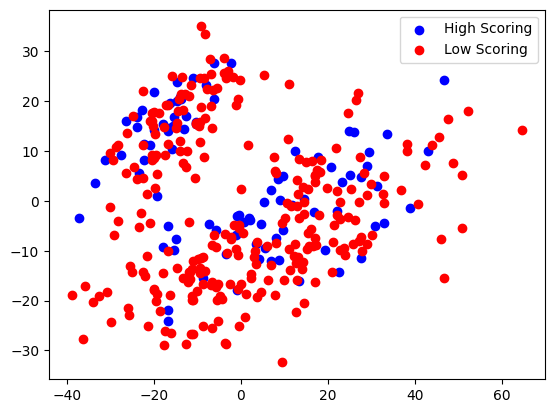

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = model.predict(images)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[high_scoring_df.index, 0], reduced_features[high_scoring_df.index, 1], c='blue', label='High Scoring')
plt.scatter(reduced_features[low_scoring_df.index, 0], reduced_features[low_scoring_df.index, 1], c='red', label='Low Scoring')
plt.legend()
plt.show()


In [15]:
from scipy.stats import f_oneway

races = df['race'].unique()
race_scores = [df[df['race'] == race]['max_pred'] for race in races]

anova_result = f_oneway(*race_scores)
print('ANOVA result:', anova_result)


ANOVA result: F_onewayResult(statistic=nan, pvalue=nan)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le_race = LabelEncoder()
df['race_encoded'] = le_race.fit_transform(df['race'])

X = df[['race_encoded']]
y = df['max_pred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 0.03931434549266244


In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
print('Feature Importances:', importances)


Feature Importances: [1.]


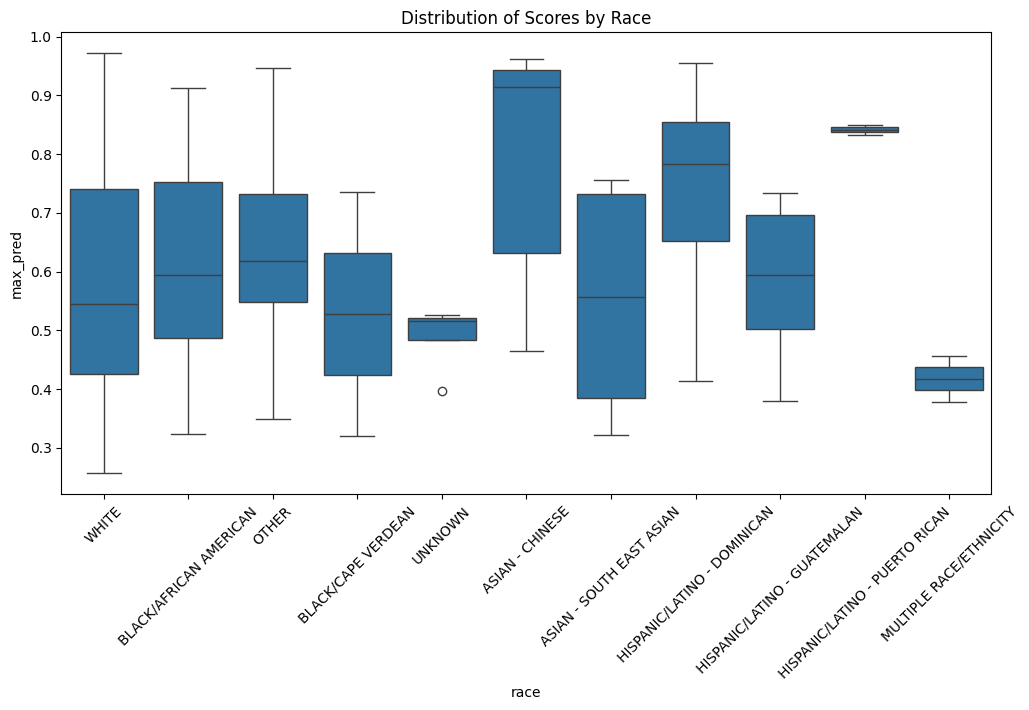

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='max_pred', data=df)
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=45)
plt.show()


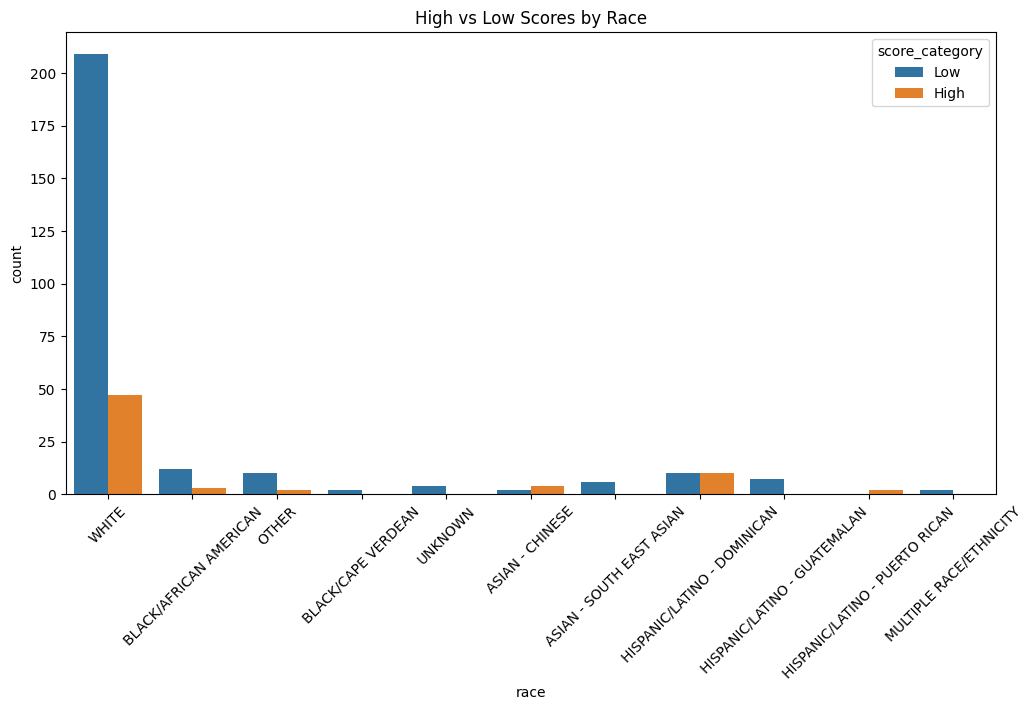

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

df['score_category'] = df['max_pred'].apply(lambda x: 'High' if x > threshold else 'Low')

plt.figure(figsize=(12, 6))
sns.countplot(x='race', hue='score_category', data=df)
plt.title('High vs Low Scores by Race')
plt.xticks(rotation=45)
plt.show()